# lesson 3

本节主要是学习如何使用Shapely, Geopandas和其他相关库管理和分析空间数据:

- Geocoding / Geocoding in Geopandas
- Conduct a Point in Polygon queries
- How to boost spatial queries using spatial index
- Make spatial and table joins between layers
- Nearest neighbour analysis

## 学习目标

- 执行geocoding，转换地址为坐标
- 执行point-in-polygon查询
- 从WFS服务和KML文件中读取数据
- 空间连接
- 执行最近邻分析，即找到最近的点

## Geocoding

geocoding，比如地址和Points之间的转换，是非常常见的GIS任务。又非常幸运的是，在python中有一些很nice的库使geocoding很容易。比如[geopy](http://geopy.readthedocs.io/en/1.11.0/)，该库通过使用第三方的geocoders和其他数据源可以很轻松的定位全球地址，城市，国家和地标的坐标。这些第三方geocoders包括：

- [ESRI ArcGIS](https://developers.arcgis.com/rest/geocode/api-reference/overview-world-geocoding-service.htm)
- [Baidu Maps](http://lbsyun.baidu.com/index.php?title=webapi/guide/webservice-geocoding)
- [Bing](https://msdn.microsoft.com/en-us/library/ff701715.aspx)
- [GeocodeFarm](https://www.geocode.farm/geocoding/free-api-documentation/)
- [GeoNames](http://www.geonames.org/export/geonames-search.html)
- [Google Geocoding API (V3)](https://developers.google.com/maps/documentation/geocoding/)
- [HERE](https://developer.here.com/documentation/geocoder/)
- [IGN France](https://geoservices.ign.fr/documentation/geoservices/index.html)
- [Mapquest](https://developer.mapquest.com/documentation/open/)
- [OpenCage](https://opencagedata.com/api)
- [OpenMapQuest](http://developer.mapquest.com/web/products/open/geocoding-service)
- [Open Street Map Nominatim](https://wiki.openstreetmap.org/wiki/Nominatim)
- [What3words](https://developer.what3words.com/public-api/docsv2#overview)
- [Yandex](https://tech.yandex.com/maps/doc/geocoder/desc/concepts/input_params-docpage/)

这些源暂时不一一记录了。总之有很多geocoders可选，他们之间有所不同。不过为了使用服务，需要从服务商那里申请API访问keys，比如google的Geocoding API，需要在谷歌云的[API控制台](https://code.google.com/apis/console)上创建项目并启动一个来自[库](https://console.developers.google.com/apis/library)的API，对google的话，在库中搜索geocoder，会出来Geocoding API，启用它即可。这里有一个如何使用Google API Console的[说明](https://developers.googleblog.com/2016/03/introducing-google-api-console.html)。使用geocoder之前需要获取google的geocoding key api，这部分可以参考谷歌文档[Get an API Key](https://developers.google.com/maps/documentation/geocoding/get-api-key)。按照文档步骤一步步即可。

不过这类服务有rate limiting，短时间内的请求太多会报错。不过可以查询[geopy文档](https://geopy.readthedocs.io/en/stable/#usage-with-pandas)看看如何处理rate limiting。

更多geocoders信息可参考:[Geocoder: Simple, Consistent](https://geocoder.readthedocs.io/)

这里选择使用Nominatim geocoder来定位较小数目的地址。该服务允许每秒1次的请求，可参考[文档](https://operations.osmfoundation.org/policies/nominatim/)

因为Nominatim是一基于OpenStreetMap data的，因此当访问的数量不大时，它不需要API key，这点非常棒！

### Geocoding in Geopandas

geopands整合了geopy的函数。geopandas的geocode()函数可以geocode一系列的地址，并返回一个包含geometry列的GeoDataframe，列中都是地址对应的点。

数据在这里下载：https://github.com/Automating-GIS-processes/site/tree/master/source/notebooks/L3/data ，直接把它整个github仓下载个zip下来解压即可，然后把L3的data文件夹内的内容放入AutoGIS/data文件夹即可。

In [2]:
# Import necessary modules
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Filepath
fp = r"data/addresses.txt"

# Read the data
data = pd.read_csv(fp, sep=';')
data.head()

,id,addr
0,1000,"Itämerenkatu 14, 00101 Helsinki, Finland"
1,1001,"Kampinkuja 1, 00100 Helsinki, Finland"
2,1002,"Kaivokatu 8, 00101 Helsinki, Finland"
3,1003,"Hermannin rantatie 1, 00580 Helsinki, Finland"
4,1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland"


In [3]:
# Import the geocoding tool
from geopandas.tools import geocode

# Geocode addresses using Nominatim. Remember to provide a custom "application name" in the user_agent parameter!
geo = geocode(data['addr'], provider='nominatim', user_agent='autogis_xx', timeout=4)

In [4]:
geo.head()

,geometry,address
0,POINT (24.91556 60.16320),"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns..."
1,POINT (24.93169 60.16902),"Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp..."
2,POINT (24.94179 60.16989),"Kauppakeskus Citycenter, 8, Kaivokatu, Keskust..."
3,POINT (24.97759 60.19361),"Hermannin rantatie, Hermanninmäki, Hermanni, K..."
4,POINT (24.92160 60.15665),"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län..."


### Table join

Table join也是GIS分析中很常用的，也就是基于相同的key属性，把不同表的数据join起来，这在geopandas中可以用merge函数实现。有时基于dataframes的index连接两个表是有用的，比如下面的例子，简言之，就是直接对应行拼接起来。

In [5]:
join = geo.join(data)
join.head()

,geometry,address,id,addr
0,POINT (24.91556 60.16320),"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland"
1,POINT (24.93169 60.16902),"Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...",1001,"Kampinkuja 1, 00100 Helsinki, Finland"
2,POINT (24.94179 60.16989),"Kauppakeskus Citycenter, 8, Kaivokatu, Keskust...",1002,"Kaivokatu 8, 00101 Helsinki, Finland"
3,POINT (24.97759 60.19361),"Hermannin rantatie, Hermanninmäki, Hermanni, K...",1003,"Hermannin rantatie 1, 00580 Helsinki, Finland"
4,POINT (24.92160 60.15665),"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland"


In [6]:
type(join)

geopandas.geodataframe.GeoDataFrame

In [7]:
# Output file path
outfp = r"data/addresses.shp"

# Save to Shapefile
join.to_file(outfp)

## Point in Polygon & Intersect

判断一个点在一个区域内还是区域外，或者看看一条线有没有和另一条线或多边形相交，都是很常见的地理空间运算。这些都是基于位置来选择数据的操作。这些空间查询是很多空间分析典型的第一步。

### 如何判断一个点在不在polygon内

这个问题有一个经典算法[Ray Casting algorithm](https://en.wikipedia.org/wiki/Point_in_polygon#Ray_casting_algorithm)。又很幸运的，the Point in Polygon (PIP) query问题不需要手写该算法，使用 [Shapely’s binary predicates](https://shapely.readthedocs.io/en/stable/manual.html#binary-predicates)可以很快的分析地理对象的空间关系。

Shapely中有两种基本方式处理PIP问题：

1. 使用.within()函数检查一个点是否在polygon内；
2. 使用.contains()检查一个polygon是否包含一个point。

同样这两个函数还可以检查LineString和Polygon是否在一个Polygon内。

In [8]:
from shapely.geometry import Point, Polygon

# Create Point objects
p1 = Point(24.952242, 60.1696017)
p2 = Point(24.976567, 60.1612500)

# Create a Polygon
coords = [(24.950899, 60.169158), (24.953492, 60.169158), (24.953510, 60.170104), (24.950958, 60.169990)]
poly = Polygon(coords)

# Let's check what we have
print(p1)
print(p2)
print(poly)

POINT (24.952242 60.1696017)
POINT (24.976567 60.16125)
POLYGON ((24.950899 60.169158, 24.953492 60.169158, 24.95351 60.170104, 24.950958 60.16999, 24.950899 60.169158))


In [9]:
# Check if p1 is within the polygon using the within function
p1.within(poly)

True

In [10]:
# Check if p2 is within the polygon
p2.within(poly)

False

In [11]:
# Our point
print(p1)

# The centroid
print(poly.centroid)

POINT (24.952242 60.1696017)
POINT (24.95224242849236 60.16960179038188)


In [12]:
# Does polygon contain p1?
poly.contains(p1)

True

In [13]:
# Does polygon contain p2?
poly.contains(p2)

False

如果有许多点，只有一个polygon，然后找出哪些点在polygon，那就循环点，使用within来判断；如果有很多polygons，有一个点，那就用contains函数。

### Intersect

另一个常用的地理空间运算是看一个geometry是否和另一个相交或接触。Shapely中有两个运算可以检验这种空间关系：

- intersect()：两个geometry，一个边界或内部以任意方式和另一个的边界或内部相交；
- touches()：两个对象，如果两个对象有至少一个共同的点，并且内部不相交，那么就是touch的。

接着直接上例子：

In [14]:
from shapely.geometry import LineString, MultiLineString

# Create two lines
line_a = LineString([(0, 0), (1, 1)])
line_b = LineString([(1, 1), (0, 2)])
line_a.intersects(line_b)

True

In [15]:
line_a.touches(line_b)

True

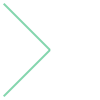

In [16]:
# Create a MultiLineString from line_a and line_b
multi_line = MultiLineString([line_a, line_b])
multi_line

In [17]:
# Does the line touch with itself?
line_a.touches(line_a)

False

In [18]:
# Does the line intersect with itself?
line_a.intersects(line_a)

True

### Point in Polygon using Geopandas

接下来一个实例是判断哪些地点在一个区域内。数据可以在[这里](https://github.com/Automating-GIS-processes/site/tree/master/source/notebooks/L3/data)下载，这里已经下载好了，不必再下载了。

In [19]:
import geopandas as gpd

fp = "data/addresses.shp"
data = gpd.read_file(fp)

data.head()

,address,id,addr,geometry
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (24.91556 60.16320)
1,"Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (24.93169 60.16902)
2,"Kauppakeskus Citycenter, 8, Kaivokatu, Keskust...",1002,"Kaivokatu 8, 00101 Helsinki, Finland",POINT (24.94179 60.16989)
3,"Hermannin rantatie, Hermanninmäki, Hermanni, K...",1003,"Hermannin rantatie 1, 00580 Helsinki, Finland",POINT (24.97759 60.19361)
4,"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",POINT (24.92160 60.15665)


在geopandas中读取KML文件和shapefile文件读取比较像。不过首先，要使能KML驱动，它不是默认可用的（因为KML文件可能包含不支持的数据结构，比如嵌套的文件夹等，因此读取KML文件要小心）。目前支持的驱动可见：[fiona.supported_drivers](https://github.com/Toblerity/Fiona/blob/master/fiona/drvsupport.py)，这些都被整合进geopandas了。

In [20]:
import geopandas as gpd
# 检查支持哪些格式
gpd.io.file.fiona.drvsupport.supported_drivers

{'ARCGEN': 'r',
 'DXF': 'rw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'FlatGeobuf': 'rw',
 'GeoJSON': 'raw',
 'GeoJSONSeq': 'rw',
 'GPKG': 'raw',
 'GML': 'rw',
 'OGR_GMT': 'rw',
 'GPX': 'rw',
 'GPSTrackMaker': 'rw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'rw',
 'OGR_PDS': 'r',
 'S57': 'r',
 'SQLite': 'raw',
 'TopoJSON': 'r'}

通过传递'rw'参数给fiona支持的驱动的白名单来使驱动有读写功能。

In [21]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

再看看支持的驱动情况：

In [22]:
gpd.io.file.fiona.drvsupport.supported_drivers

{'ARCGEN': 'r',
 'DXF': 'rw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'FlatGeobuf': 'rw',
 'GeoJSON': 'raw',
 'GeoJSONSeq': 'rw',
 'GPKG': 'raw',
 'GML': 'rw',
 'OGR_GMT': 'rw',
 'GPX': 'rw',
 'GPSTrackMaker': 'rw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'rw',
 'OGR_PDS': 'r',
 'S57': 'r',
 'SQLite': 'raw',
 'TopoJSON': 'r',
 'KML': 'rw'}

可以看到KML已经是可读写的了。现在可以读取KML文件了。

In [23]:
# Filepath to KML file
fp = "data/PKS_suuralue.kml"
polys = gpd.read_file(fp, driver='KML')
#Check the data
print("Number of rows:",len(polys))
polys.head(11)

Number of rows: 23


,Name,Description,geometry
0,Suur-Espoonlahti,,"POLYGON Z ((24.77506 60.10906 0.00000, 24.7766..."
1,Suur-Kauklahti,,"POLYGON Z ((24.61578 60.17257 0.00000, 24.6155..."
2,Vanha-Espoo,,"POLYGON Z ((24.67576 60.21201 0.00000, 24.6752..."
3,Pohjois-Espoo,,"POLYGON Z ((24.76792 60.26920 0.00000, 24.7699..."
4,Suur-Matinkylä,,"POLYGON Z ((24.75361 60.16631 0.00000, 24.7537..."
5,Kauniainen,,"POLYGON Z ((24.69075 60.21958 0.00000, 24.6924..."
6,Suur-Leppävaara,,"POLYGON Z ((24.79747 60.20827 0.00000, 24.7954..."
7,Suur-Tapiola,,"POLYGON Z ((24.84436 60.16598 0.00000, 24.8443..."
8,Myyrmäki,,"POLYGON Z ((24.82459 60.29025 0.00000, 24.8243..."
9,Kivistö,,"POLYGON Z ((24.94309 60.33845 0.00000, 24.9421..."


可以看到数据已经读出，例子中有23个地区，都是polygon。

<AxesSubplot:>

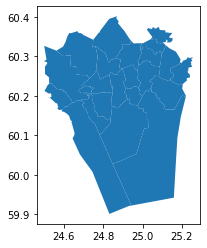

In [24]:
%matplotlib inline
polys.plot()

这里作为例子的感兴趣的地区是Eteläinen (‘Southern’ in English).

选出该区域来运算。

In [25]:
# Select data
southern = polys.loc[polys['Name']=='Eteläinen']
# Reset index for the selection
southern.reset_index(drop=True, inplace=True)
# Check the selction
southern.head()

,Name,Description,geometry
0,Eteläinen,,"POLYGON Z ((24.78277 60.09997 0.00000, 24.8197..."


接下来，首先画出这个感兴趣的区域，然后再把地点都标到地图上。

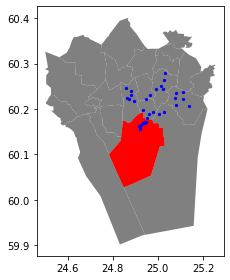

In [26]:
import matplotlib.pyplot as plt

# Create a figure with one subplot
fig, ax = plt.subplots()

# Plot polygons
polys.plot(ax=ax, facecolor='gray')
southern.plot(ax=ax, facecolor='red')

# Plot points
data.plot(ax=ax, color='blue', markersize=5)

plt.tight_layout()

可以看到有一些点是在红色区域内的。接着就执行那个PIP操作。首先，检查下有没有使shapely.speedups可用。该module可以使空间查询执行更快（从shapely 1.6.0开始，加速是默认的）。

In [27]:
#import shapely.speedups
from shapely import speedups
speedups.enabled

# If false, run this line:
#shapely.speedups.enable()

True

现在来检查下哪些点在southern polygon中。check if the Points are within the geometry of the southern GeoDataFrame.

In [28]:
pip_mask = data.within(southern.at[0, 'geometry'])
print(pip_mask)

0      True
1      True
2      True
3     False
4      True
5     False
6     False
7     False
8     False
9     False
10     True
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30     True
31     True
32     True
33     True
dtype: bool


如上结果所示，得到很多boolean值。为True的就是point在polygon中的，false的就是不在的。现在可以用mask来选择在polygon中的点了。通过pandas的索引，可以很容易实现。

In [29]:
pip_data = data.loc[pip_mask]
pip_data

,address,id,addr,geometry
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (24.91556 60.16320)
1,"Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (24.93169 60.16902)
2,"Kauppakeskus Citycenter, 8, Kaivokatu, Keskust...",1002,"Kaivokatu 8, 00101 Helsinki, Finland",POINT (24.94179 60.16989)
4,"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",POINT (24.92160 60.15665)
10,"Rautatientori, Kaisaniemi, Kluuvi, Eteläinen s...",1011,"Rautatientori 1, 00100 Helsinki, Finland",POINT (24.94410 60.17133)
30,"Kampin keskus, 1, Urho Kekkosen katu, Kamppi, ...",1031,"Urho Kekkosen katu 1, 00100 Helsinki, Finland",POINT (24.93312 60.16909)
31,"Ruoholahdenkatu, Hietalahti, Kamppi, Eteläinen...",1032,"Ruoholahdenkatu 17, 00101 Helsinki, Finland",POINT (24.92520 60.16489)
32,"Easy Cycles, 3, Tyynenmerenkatu, Jätkäsaari, L...",1033,"Tyynenmerenkatu 3, 00220 Helsinki, Finland",POINT (24.92119 60.15890)
33,"Oluthuone Kaisla, 4, Vilhonkatu, Kaisaniemi, K...",1034,"Vilhonkatu 4, 00101 Helsinki, Finland",POINT (24.94709 60.17191)


最后可视化结果确认下PIP查询执行的效果。

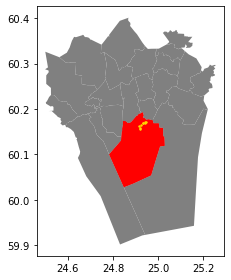

In [30]:
# Create a figure with one subplot
fig, ax = plt.subplots()

# Plot polygons
polys.plot(ax=ax, facecolor='gray')
southern.plot(ax=ax, facecolor='red')

# Plot points
pip_data.plot(ax=ax, color='gold', markersize=2)

plt.tight_layout()

至此，就把包含在polygon中的点找出来了。

## Spatial index - How to boost spatial queries

从性能的角度来说，之前的例子中用的方法都是比较慢的。尤其是面对大数据集的时候，PIP会非常慢，这会成为一个瓶颈。

又幸运地是有一种称为spatial index的解决办法，能显著地提升空间查询的性能。比如基于R-tree数据结构的空间索引。这里就不展开了，总之是一种索引性能不错的tree的结构，以分组的形式聚集了相邻对象，然后重复了几次该过程构建了一个树结构，每个节点都有自己的范围。如下图所示

![](pictures/Rtree-IBM.png)

直接上例子。

In [31]:
import geopandas as gpd

# Filepaths
intersections_fp = "data/uusimaa_intersections.gpkg"
postcode_areas_fp = "data/uusimaa_postal_code_areas.gpkg"

intersections = gpd.read_file(intersections_fp)
postcode_areas = gpd.read_file(postcode_areas_fp)

# Let's check first rows
print(intersections.head(), '\n-------')
print(postcode_areas.head())

            x            y                        geometry
0  330888.502  6675829.949  POINT (330888.502 6675829.949)
1  348059.990  6670041.685  POINT (348059.990 6670041.685)
2  348022.592  6670202.858  POINT (348022.592 6670202.858)
3  297208.220  6669048.357  POINT (297208.220 6669048.357)
4  330835.341  6675586.834  POINT (330835.341 6675586.834) 
-------
  posti_alue  he_vakiy                                           geometry
0      00100   18284.0  MULTIPOLYGON (((385653.893 6671591.048, 385573...
1      00120    7108.0  MULTIPOLYGON (((385316.092 6671076.984, 385279...
2      00130    1508.0  MULTIPOLYGON (((386212.111 6671061.262, 386176...
3      00140    7865.0  MULTIPOLYGON (((386577.050 6670280.544, 386552...
4      00150    9496.0  MULTIPOLYGON (((384846.102 6669565.816, 384823...


上面的两个shape图，一个是point组成的，代表的是道路交点，另一个是多边形的，代表的是邮编区域。用下面的程序可以看到有数万个点，几百的区域，这是足够大来看看spatial index的效果了。

In [32]:
print("Number of intersections:", len(intersections))
print("Number of postal code areas:", len(postcode_areas))

Number of intersections: 63518
Number of postal code areas: 370


先可视化下，对数据有整体上的把握：

(6667500.0, 6680000.0)

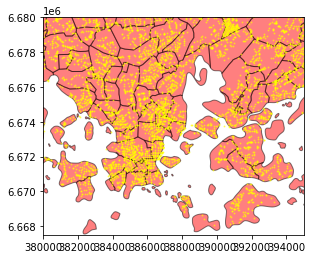

In [33]:
%matplotlib inline
ax = postcode_areas.plot(color='red', edgecolor='black', alpha=0.5)
ax = intersections.plot(ax=ax, color='yellow', markersize=1, alpha=0.5)

# Zoom to closer (comment out the following to see the full extent of the data)
ax.set_xlim([380000, 395000])
ax.set_ylim([6667500, 6680000])

接下来，目标是计算在每个区域内有多少个点。这里就要利用spatial index的优点了。在geopandas中构建spatial index可以通过调用.sindex属性来轻松实现。

In [34]:
# Let's build spatial index for intersection points
intersection_sindex = intersections.sindex

# Let's see what it is
intersection_sindex

rtree.index.Index(bounds=[266574.119, 6632767.892, 419357.063, 6745429.931], size=63518)

如上结果所示，变量是有SpatialIndex对象属性的。对象包含了以R树数据结构形式的geometries。

In [35]:
# How many groups do we have?
print("Number of groups:", len(intersection_sindex.leaves()), '\n')

# Print some basic info for few of them
n_iterations = 10
for i, group in enumerate(intersection_sindex.leaves()):
    group_idx, indices, bbox = group
    print("Group", group_idx, "contains ", len(indices), "geometries, bounding box:", bbox)
    i+=1
    if i == n_iterations:
        break

Number of groups: 908 

Group 0 contains  70 geometries, bounding box: [270305.195, 6632767.892, 279497.993, 6638674.424]
Group 2 contains  70 geometries, bounding box: [272155.57, 6638680.047, 285753.31, 6638976.355]
Group 3 contains  70 geometries, bounding box: [271904.727, 6638983.54, 286463.059, 6639181.123]
Group 4 contains  70 geometries, bounding box: [271790.007, 6639184.018, 284495.801, 6639351.784]
Group 5 contains  70 geometries, bounding box: [271952.787, 6639354.724, 284589.912, 6639564.576]
Group 6 contains  70 geometries, bounding box: [271784.854, 6639571.546, 285241.406, 6639760.222]
Group 7 contains  70 geometries, bounding box: [271813.417, 6639762.182, 285147.276, 6639945.834]
Group 8 contains  70 geometries, bounding box: [271646.281, 6639949.717, 283451.674, 6640149.228]
Group 9 contains  70 geometries, bounding box: [272335.073, 6640150.564, 282567.285, 6640318.718]
Group 10 contains  70 geometries, bounding box: [272318.947, 6640321.762, 286352.142, 6641062.815

如上结果所示，共有908个组，每个组有70个geometries。为了执行快速空间查询，可以利用spatial index，并比较area的code和点的R树空间索引的bounding boxes。首先选择一个区域：

<AxesSubplot:>

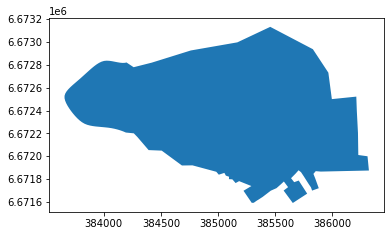

In [36]:
# Select a postal code area representing the city center of Helsinki
city_center_zip_area = postcode_areas.loc[postcode_areas['posti_alue']=='00100']
city_center_zip_area.plot()

现在进行PIP，分两步：

1. 比较polygon的边界和points的spatial index，这样可以先得到一组候选点，这些点都是可能在polygon中的；
2. 再遍历这些候选点，得到最终的结果。

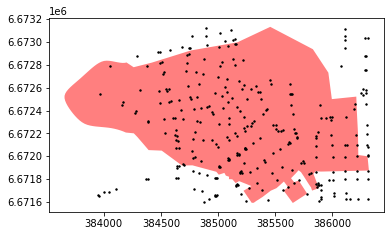

In [37]:
# Get the bounding box coordinates of the Polygon as a list
bounds = list(city_center_zip_area.bounds.values[0])

# Get the indices of the Points that are likely to be inside the bounding box of the given Polygon
point_candidate_idx = list(intersection_sindex.intersection(bounds))
point_candidates = intersections.loc[point_candidate_idx]

# Let's see what we have now
ax = city_center_zip_area.plot(color='red', alpha=0.5)
ax = point_candidates.plot(ax=ax, color='black', markersize=2)

如上图结果所示，先里bound和点的空间索引相交快速找到了可能的点（个人理解，可能是tree的结果也是矩形，和bound比较好一起分析吧）。然后再进行normal的PIP判断。

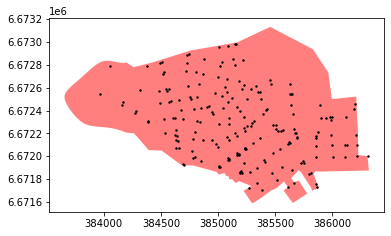

In [38]:
# Make the precise Point in Polygon query
final_selection = point_candidates.loc[point_candidates.intersects(city_center_zip_area['geometry'].values[0])]

# Let's see what we have now
ax = city_center_zip_area.plot(color='red', alpha=0.5)
ax = final_selection.plot(ax=ax, color='black', markersize=2)

然后比较一下spatial index和传统方法的时间差别。

In [39]:
def intersect_using_spatial_index(source_gdf, intersecting_gdf):
    """
    Conduct spatial intersection using spatial index for candidates GeoDataFrame to make queries faster.
    Note, with this function, you can have multiple Polygons in the 'intersecting_gdf' and it will return all the points
    intersect with ANY of those geometries.
    """
    source_sindex = source_gdf.sindex
    possible_matches_index = []

    # 'itertuples()' function is a faster version of 'iterrows()'
    for other in intersecting_gdf.itertuples():
        bounds = other.geometry.bounds
        c = list(source_sindex.intersection(bounds))
        possible_matches_index += c

    # Get unique candidates
    unique_candidate_matches = list(set(possible_matches_index))
    possible_matches = source_gdf.iloc[unique_candidate_matches]

    # Conduct the actual intersect
    result = possible_matches.loc[possible_matches.intersects(intersecting_gdf.unary_union)]
    return result

In [40]:
def normal_intersect(source_gdf, intersecting_gdf):
    """
    Conduct spatial intersection without spatial index.
    Note, with this function, you can have multiple Polygons in the 'intersecting_gdf' and it will return all the points
    intersect with ANY of those geometries.
    """

    matches = []

    # 'itertuples()' function is a faster version of 'iterrows()'
    for other in intersecting_gdf.itertuples():
        c = list(source_gdf.loc[source_gdf.intersects(other.geometry)].index)
        matches += c

    # Get all points that are intersecting with the Polygons
    unique_matches = list(set(matches))
    result = source_gdf.loc[source_gdf.index.isin(unique_matches)]
    return result

In [41]:
# Test the spatial query with spatial index
%timeit intersect_using_spatial_index(source_gdf=intersections, intersecting_gdf=city_center_zip_area)

51.7 ms ± 4.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [42]:
# Test the spatial query without spatial index
%timeit normal_intersect(source_gdf=intersections, intersecting_gdf=city_center_zip_area)

302 ms ± 26.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


在一个多边形中分析，差别显不出来，但是在成百上千个polygons里分析，那差别就大了。

接下来就完成目标的最后一步，数交点。这步可以通过spatial join来快速实现。

In [43]:
# Count intersections by postal code area
intersection_cnt = gpd.sjoin(postcode_areas, intersections).groupby('posti_alue').size().reset_index()
intersection_cnt.head()

,posti_alue,0
0,00100,203
1,00120,35
2,00130,50
3,00140,44
4,00150,68


In [44]:
# Merge with postcode data and plot
intersection_cnt = intersection_cnt.rename(columns={0: 'intersection_cnt'})
postcode_areas = postcode_areas.merge(intersection_cnt, on='posti_alue')
postcode_areas

,posti_alue,he_vakiy,geometry,intersection_cnt
0,00100,18284.0,"MULTIPOLYGON (((385653.893 6671591.048, 385573...",203
1,00120,7108.0,"MULTIPOLYGON (((385316.092 6671076.984, 385279...",35
2,00130,1508.0,"MULTIPOLYGON (((386212.111 6671061.262, 386176...",50
3,00140,7865.0,"MULTIPOLYGON (((386577.050 6670280.544, 386552...",44
4,00150,9496.0,"MULTIPOLYGON (((384846.102 6669565.816, 384823...",68
...,...,...,...,...
338,25470,279.0,"MULTIPOLYGON (((305067.212 6673543.615, 304620...",16
339,25500,3391.0,"MULTIPOLYGON (((277988.374 6665076.564, 277959...",86
340,25560,208.0,"MULTIPOLYGON (((294139.092 6671931.426, 291442...",48
341,31350,235.0,"MULTIPOLYGON (((329443.822 6726297.286, 329125...",2


<AxesSubplot:>

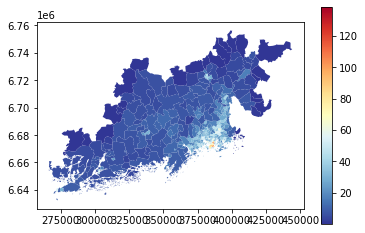

In [45]:
# Plot intersection density (number of intersections per square kilometer inside a Postal code)
m2_to_km2_converter = 1000000
postcode_areas['intersection_density'] = postcode_areas['intersection_cnt'] / (postcode_areas.area / m2_to_km2_converter)
postcode_areas.plot('intersection_density', cmap='RdYlBu_r', legend=True)

上图结果显示的是各区域点的密度。 值得注意的是如果polygon和点的bound范围差不多，那么使用spatial index并不会提高多少速度。

![](pictures/los-angeles-boundary-intersections.png)

这时候，可以把area切割，然后再利用spatial index。

![](pictures/los-angeles-boundary-quadrats-intersections.png)

## Spatial join

空间连接时一个经典的GIS问题。即将一个图层的属性放到另一个与它有空间关系的图层中去。接下来给的例子是结合PIP，基于空间关系空间连接两个图层。例子是个很经典的问题：连接一个polygon图层和一个point图层，每个point会得到包含它的polygon的属性。

又幸运地是，空间连接已经在geopandas中实现了，因此没有必要再自己创建函数了。有三种用于空间连接的连接类型，在gpd.sjoin()函数中通过op参数可以决定：

- intersects
- within
- contains

这些关系和前面PIP中探讨的类似。再复述下，intersects就是两个对象只要有边界或内部相交，就是相交了；within是说point在polygon中；contains是说polygon包含point。

另外，通过配置how参数，left,right,inner可以实现不同类型的连接方式，这个有点像sql里的内容。下面上例子：

In [46]:
import geopandas as gpd
from pyproj import CRS
import requests
import geojson

# Specify the url for web feature service
url = 'https://kartta.hsy.fi/geoserver/wfs'

# Specify parameters (read data in json format). 
# Available feature types in this particular data source: http://geo.stat.fi/geoserver/vaestoruutu/wfs?service=wfs&version=2.0.0&request=describeFeatureType
params = dict(service='WFS', 
              version='2.0.0', 
              request='GetFeature', 
              typeName='asuminen_ja_maankaytto:Vaestotietoruudukko_2018', 
              outputFormat='json')

# Fetch data from WFS using requests
r = requests.get(url, params=params)

# Create GeoDataFrame from geojson
pop = gpd.GeoDataFrame.from_features(geojson.loads(r.content))
pop.head()

,geometry,index,asukkaita,asvaljyys,ika0_9,ika10_19,ika20_29,ika30_39,ika40_49,ika50_59,ika60_69,ika70_79,ika_yli80
0,"MULTIPOLYGON (((25472499.995 6689749.005, 2547...",688,9,28.0,99,99,99,99,99,99,99,99,99
1,"MULTIPOLYGON (((25472499.995 6685998.998, 2547...",703,5,51.0,99,99,99,99,99,99,99,99,99
2,"MULTIPOLYGON (((25472499.995 6684249.004, 2547...",710,8,44.0,99,99,99,99,99,99,99,99,99
3,"MULTIPOLYGON (((25472499.995 6683999.005, 2547...",711,5,90.0,99,99,99,99,99,99,99,99,99
4,"MULTIPOLYGON (((25472499.995 6682998.998, 2547...",715,11,41.0,99,99,99,99,99,99,99,99,99


In [47]:
# Change the name of a column
pop = pop.rename(columns={'asukkaita': 'pop18'})

# Check the column names
pop.columns

Index(['geometry', 'index', 'pop18', 'asvaljyys', 'ika0_9', 'ika10_19',
       'ika20_29', 'ika30_39', 'ika40_49', 'ika50_59', 'ika60_69', 'ika70_79',
       'ika_yli80'],
      dtype='object')

In [48]:
# Subset columns
pop = pop[["pop18", "geometry"]]
pop.head()

,pop18,geometry
0,9,"MULTIPOLYGON (((25472499.995 6689749.005, 2547..."
1,5,"MULTIPOLYGON (((25472499.995 6685998.998, 2547..."
2,8,"MULTIPOLYGON (((25472499.995 6684249.004, 2547..."
3,5,"MULTIPOLYGON (((25472499.995 6683999.005, 2547..."
4,11,"MULTIPOLYGON (((25472499.995 6682998.998, 2547..."


目标是知道包含一个地点的每个polygon中有多少人居住。所以要把人口的属性加到地点的图层里。

In [49]:
# Addresses filpath
addr_fp = r"data/addresses.shp"

# Read data
addresses = gpd.read_file(addr_fp)

# Check the head of the file
addresses.head()

,address,id,addr,geometry
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (24.91556 60.16320)
1,"Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (24.93169 60.16902)
2,"Kauppakeskus Citycenter, 8, Kaivokatu, Keskust...",1002,"Kaivokatu 8, 00101 Helsinki, Finland",POINT (24.94179 60.16989)
3,"Hermannin rantatie, Hermanninmäki, Hermanni, K...",1003,"Hermannin rantatie 1, 00580 Helsinki, Finland",POINT (24.97759 60.19361)
4,"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",POINT (24.92160 60.15665)


首先还是要检查CRS是否一样。

In [50]:
addresses.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [51]:
pop.crs

根据数据源的介绍，pop的坐标是ETRS GK-25 (EPSG:3879) 

In [52]:
# Define crs
pop.crs = CRS.from_epsg(3879).to_wkt()
pop.crs

<Projected CRS: EPSG:3879>
Name: ETRS89 / GK25FIN
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Finland - nominally onshore between 24°30'E and 25°30'E but may be used in adjacent areas if a municipality chooses to use one zone over its whole extent.
- bounds: (24.5, 59.94, 25.5, 68.9)
Coordinate Operation:
- name: Finland Gauss-Kruger zone 25
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [53]:
addresses.crs == pop.crs

False

两者坐标不同，因此需要reproject

In [54]:
addresses = addresses.to_crs(pop.crs)
# Check the crs of address points
print(addresses.crs)
# Check the crs of population layer
print(pop.crs)
# Do they match now?
addresses.crs == pop.crs

PROJCRS["ETRS89 / GK25FIN",BASEGEOGCRS["ETRS89",ENSEMBLE["European Terrestrial Reference System 1989 ensemble",MEMBER["European Terrestrial Reference Frame 1989"],MEMBER["European Terrestrial Reference Frame 1990"],MEMBER["European Terrestrial Reference Frame 1991"],MEMBER["European Terrestrial Reference Frame 1992"],MEMBER["European Terrestrial Reference Frame 1993"],MEMBER["European Terrestrial Reference Frame 1994"],MEMBER["European Terrestrial Reference Frame 1996"],MEMBER["European Terrestrial Reference Frame 1997"],MEMBER["European Terrestrial Reference Frame 2000"],MEMBER["European Terrestrial Reference Frame 2005"],MEMBER["European Terrestrial Reference Frame 2014"],ELLIPSOID["GRS 1980",6378137,298.257222101,LENGTHUNIT["metre",1]],ENSEMBLEACCURACY[0.1]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4258]],CONVERSION["Finland Gauss-Kruger zone 25",METHOD["Transverse Mercator",ID["EPSG",9807]],PARAMETER["Latitude of natural origin",0,ANGLEUNIT["degree",0.

True

crs一致之后，可以开始空间连接了。

In [55]:
# Make a spatial join
join = gpd.sjoin(addresses, pop, how="inner", op="within")
join.head()

,address,id,addr,geometry,index_right,pop18
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (25495311.608 6672258.695),3252,515
1,"Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (25496207.840 6672906.173),3364,182
2,"Kauppakeskus Citycenter, 8, Kaivokatu, Keskust...",1002,"Kaivokatu 8, 00101 Helsinki, Finland",POINT (25496768.622 6673002.004),3488,38
10,"Rautatientori, Kaisaniemi, Kluuvi, Eteläinen s...",1011,"Rautatientori 1, 00100 Helsinki, Finland",POINT (25496896.734 6673162.114),3488,38
4,"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",POINT (25495645.995 6671528.068),3298,1435


现在已经完成空间连接了，并且得到了一个新的geodataframe。index_right 是匹配的点在其中的polygon，还有pop18属性。

In [56]:
len(join)

30

In [57]:
len(addresses)

34

<AxesSubplot:>

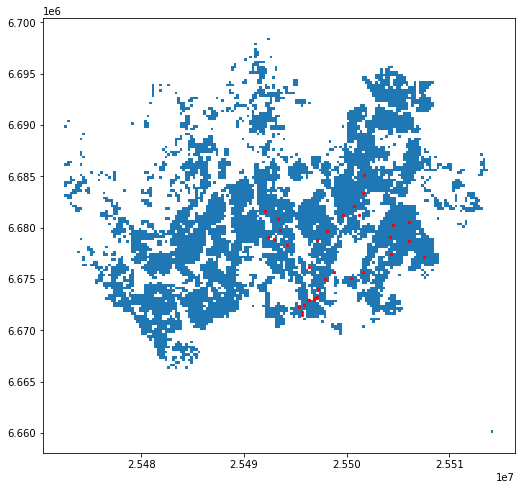

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt

# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(15,8))

# Plot population grid
pop.plot(ax=ax)

# Plot points
addresses.plot(ax=ax, color='red', markersize=5)

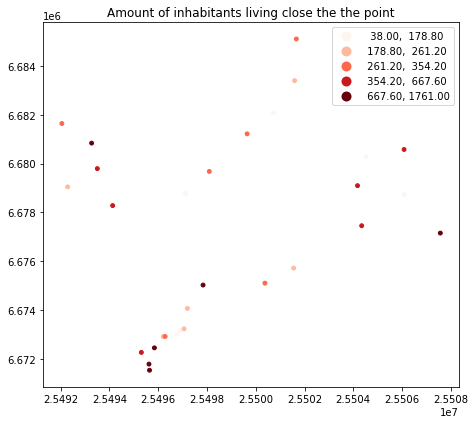

In [59]:
# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(10,6))

# Plot the points with population info
join.plot(ax=ax, column='pop18', cmap="Reds", scheme="quantiles", markersize=15, legend=True);

# Add title
plt.title("Amount of inhabitants living close the the point");

# Remove white space around the figure
plt.tight_layout()

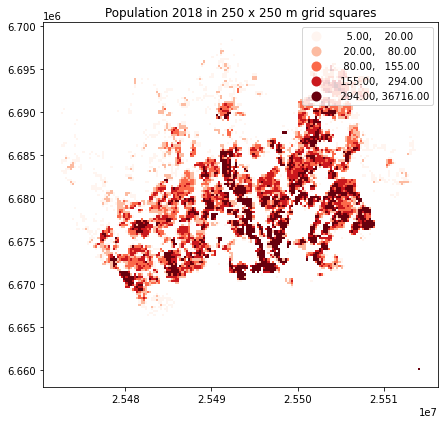

In [60]:
# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(10,6))

# Plot the grid with population info
pop.plot(ax=ax, column='pop18', cmap="Reds", scheme="quantiles", legend=True);

# Add title
plt.title("Population 2018 in 250 x 250 m grid squares");

# Remove white space around the figure
plt.tight_layout()

In [61]:
# Output path
outfp = r"data/addresses_population.shp"

# Save to disk
join.to_file(outfp)

C:\Users\hust2\AppData\Local\Temp/ipykernel_11588/218676674.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  join.to_file(outfp)
